Management has contracted an HR analytics firm, Xander Talent HR, to understand what JWC can do to stop minimise attrition as much as possible. They want to know what changes they should make to their workplace, in order to get most of their employees to stay. Also, they want to know which of these variables is most important and needs to be addressed right away.

Report the attributes of attrition and what other patterns you can recognise related attrition. The results thus obtained will be used by the management to understand what changes they should make to their workplace, in order to get most of their employees to stay.

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import statistics
# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [3]:
import psycopg2 #import database library 

In [4]:
conn= psycopg2.connect(dbname="HRdb",user="postgres",password="sarah") #create connection object

In [5]:
#cur=conn.cursor() #cursor created has a method execute, which will recieve SQL parameters to run against the database

In [6]:
%%time
df=pd.read_sql('select * from general_data left join employee_survey_data on general_data."EmployeeID" = employee_survey_data."EmployeeID"left join manager_survey_data on general_data."EmployeeID" = manager_survey_data."EmployeeID";'
               ,conn) #use pandas to directly import the data

Wall time: 545 ms


In [7]:
conn.close()

In [8]:
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,EmployeeID,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1,0,0,1,3.0,4.0,2.0,1,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,5,1,4,2,3.0,2.0,4.0,2,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5,0,3,3,2.0,2.0,1.0,3,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,8,7,5,4,4.0,4.0,3.0,4,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,6,0,4,5,4.0,1.0,3.0,5,3,3


In [9]:
df.duplicated().any()

False

The data doesn't have any duplicated entries.

In [10]:
# remove duplicate columns
df = df.loc[:,~df.columns.duplicated()].copy() 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

WorkLifeBalance, JobSatisfaction, EnvironmentSatisfaction, NumCompaniesWorked, and TotalWorkingYears have missing entries (not recorded). 

In [12]:
df.loc[(df['NumCompaniesWorked']==0),["NumCompaniesWorked","TotalWorkingYears","YearsAtCompany"]]

,NumCompaniesWorked,TotalWorkingYears,YearsAtCompany
1,0.0,6.0,5
8,0.0,10.0,9
10,0.0,21.0,20
11,0.0,16.0,15
12,0.0,37.0,36
...,...,...,...
4396,0.0,25.0,24
4403,0.0,20.0,19
4407,0.0,5.0,4
4408,0.0,10.0,9


We can see that if NumCompaniesWorked == 0, then the employee has only ever worked for JWC therefore TotalWorkingYears=YearsAtCompany +1

In [13]:
# replacing null values in NumCompaniesWorked if equal to 0 
df.loc[df['NumCompaniesWorked'].eq(0), 'TotalWorkingYears'] = df['YearsAtCompany']+1

In [14]:
df.set_index('EmployeeID', inplace=True)

### Validating Data

In [15]:
df.describe()

,Age,DistanceFromHome,Education,EmployeeCount,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
count,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4391.000000,4410.000000,4410.0,4410.000000,4403.000000,4410.000000,4410.000000,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.000000
mean,36.923810,9.192517,2.912925,1.0,2.063946,65029.312925,2.694830,15.209524,8.0,0.793878,11.282308,2.799320,7.008163,2.187755,4.123129,2.723603,2.728246,2.761436,2.729932,3.153741
std,9.133301,8.105026,1.023933,0.0,1.106689,47068.888559,2.498887,3.659108,0.0,0.851883,7.782132,1.288978,6.125135,3.221699,3.567327,1.092756,1.101253,0.706245,0.711400,0.360742
min,18.000000,1.000000,1.000000,1.0,1.000000,10090.000000,0.000000,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,30.000000,2.000000,2.000000,1.0,1.000000,29110.000000,1.000000,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000
50%,36.000000,7.000000,3.000000,1.0,2.000000,49190.000000,2.000000,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,43.000000,14.000000,4.000000,1.0,3.000000,83800.000000,4.000000,18.000000,8.0,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000
max,60.000000,29.000000,5.000000,1.0,5.000000,199990.000000,9.000000,25.000000,8.0,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [16]:
df.Over18.unique() # check entries of all features 

array(['Y'], dtype=object)

In [17]:
df.EmployeeCount.unique()

array([1], dtype=int64)

In [18]:
df.StandardHours.unique()

array([8], dtype=int64)

With the minimum age being 18 and all the values in the Over18 column being the same, this feature can be removed. EmployeeCount and StandardHours also has only one unique entry. 

In [19]:
df.drop(columns=['Over18', 'EmployeeCount','StandardHours'], inplace=True) # drop unwanted columns 

In [20]:
# checking invalid entries where YearsAtCompany>TotalWorkingYears
df.loc[(df.YearsAtCompany) > (df.TotalWorkingYears)]

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
EmployeeID,,,,,,,,,,,,,,,,,,,,,


In [21]:
# checking invalid entries where YearsSinceLastPromotion>YearsAtCompany
df.loc[(df.YearsSinceLastPromotion) > (df.YearsAtCompany)]

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
EmployeeID,,,,,,,,,,,,,,,,,,,,,


In [22]:
# checking invalid entries where YearsWithCurrManager>YearsAtCompany
df.loc[(df.YearsWithCurrManager) > (df.YearsAtCompany)]

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
EmployeeID,,,,,,,,,,,,,,,,,,,,,


No invalid entries between columns relating to years.

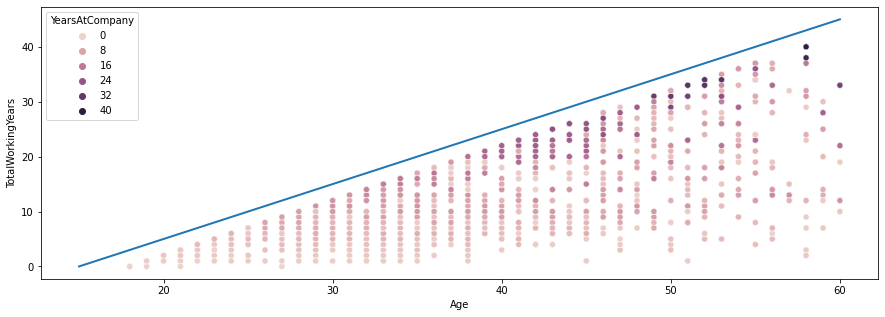

In [23]:
# check if TotalWorkingYears is valid with Age
plt.figure(figsize = (15,5))
sns.scatterplot(x='Age', y='TotalWorkingYears', hue = 'YearsAtCompany', data = df )
plt.plot([15, 60], [0, 45], linewidth=2) # threshold for total working years if started work at 16.
plt.show()

Age of employees against total working years is valid, as all enties lie below the threshold.

In [24]:
# JobLevel & Monthly Income 
df.groupby(['Department','JobLevel'])['MonthlyIncome'].agg([min,max])

min     max
Department             JobLevel               
Human Resources        1         13930  190810
                       2         24130  168850
                       3         22580  136750
                       4         43190   74280
                       5         24550   76320
Research & Development 1         10910  199260
                       2         10510  199990
                       3         10520  199730
                       4         14200  195370
                       5         23420  196360
Sales                  1         12320  196650
                       2         10090  198590
                       3         11290  194190
                       4         11180  194360
                       5         12000  103250

Inconsistencies with income and job level, this may be because JobLevel was not entered accurately. Other variables may also affect income e.g age/experince 

In [25]:
# JobLevel & Age
df.groupby(['JobLevel'])['Age'].agg([min,max])

,min,max
JobLevel,,
1,18,60
2,18,60
3,18,59
4,21,60
5,19,60


In [26]:
# checking if joblevel is valid against age
df.loc[((df.Age) <=21)&((df.JobLevel) ==5)].shape

(12, 25)

12 enteries where under 21 employees have a highlevel job 

In [27]:
# checking if education is valid against age
df.loc[((df.Age) <=19)&((df.Education) >2)].shape

(39, 25)

There are 39 records where 19/18 year olds have a bachelors, masters or doctorate 

Records will be kept as is.

### Univariate Analysis

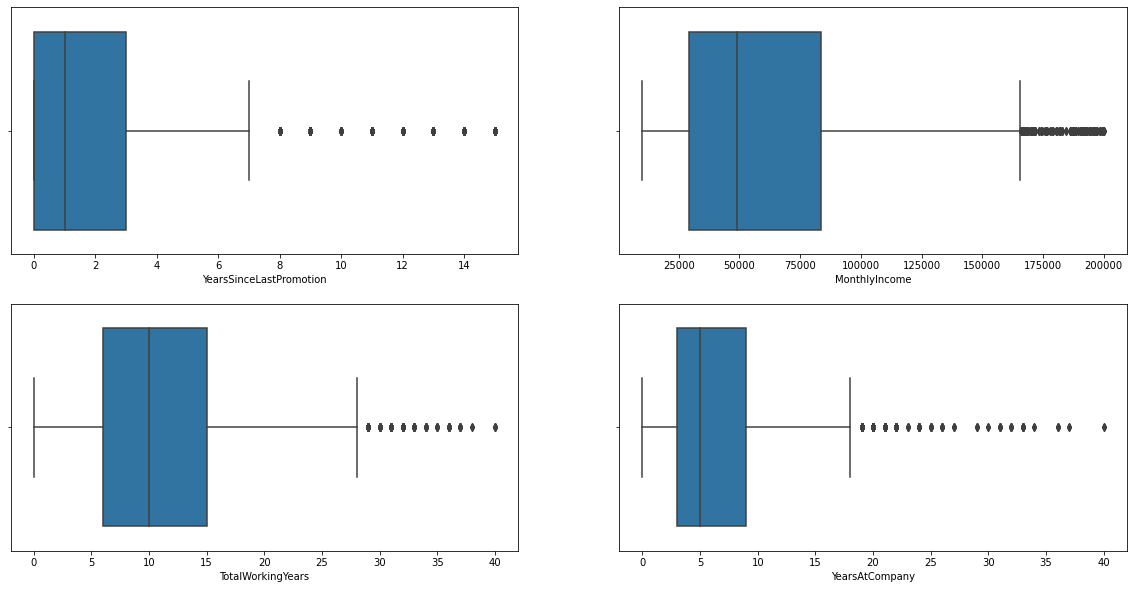

In [28]:
fig, axes = plt.subplots(2, 2,figsize=(20,10))
sns.boxplot(x = 'YearsSinceLastPromotion', data = df,ax=axes[0,0])
sns.boxplot(x = 'MonthlyIncome', data = df,ax=axes[0,1])
sns.boxplot(x = 'TotalWorkingYears', data = df,ax=axes[1,0])
sns.boxplot(x = 'YearsAtCompany', data = df,ax=axes[1,1])
plt.show()
#testing all features for outliers

These features show significat outliers. Not sure if outlier treatment is neccesary here considering the following histograms. 

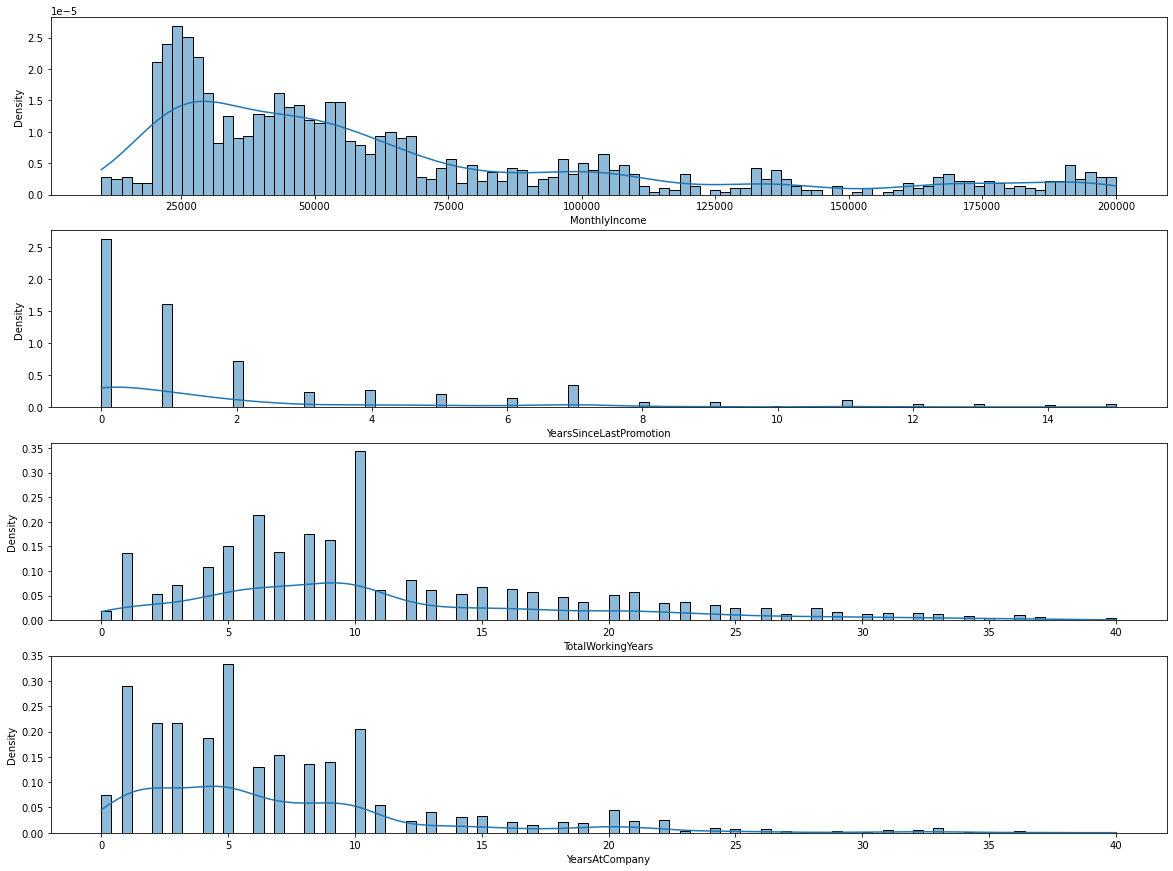

In [29]:
fig, axes = plt.subplots(4, 1,figsize=(20,15))
sns.histplot(x = 'MonthlyIncome', data = df,kde=True,stat='density', ax=axes[0], bins = 100)
sns.histplot(x = 'YearsSinceLastPromotion',data = df,kde=True,stat='density', ax=axes[1], bins = 100)
sns.histplot(x = 'TotalWorkingYears', data = df,kde=True,stat='density', ax=axes[2], bins = 100)
sns.histplot(x = 'YearsAtCompany', data = df,kde=True,stat='density', ax=axes[3], bins = 100)
plt.show()

Features are heavily skewed (require treatment for machine learning). 

In [30]:
#Checking skew of numerical features
df.skew(axis = 0, skipna = True, numeric_only=True)

Age                        0.413005
DistanceFromHome           0.957466
Education                 -0.289484
JobLevel                   1.024703
MonthlyIncome              1.368884
NumCompaniesWorked         1.026767
PercentSalaryHike          0.820569
StockOptionLevel           0.968321
TotalWorkingYears          1.116042
TrainingTimesLastYear      0.552748
YearsAtCompany             1.763328
YearsSinceLastPromotion    1.982939
YearsWithCurrManager       0.832884
EnvironmentSatisfaction   -0.323295
JobSatisfaction           -0.328622
WorkLifeBalance           -0.557041
JobInvolvement            -0.498080
PerformanceRating          1.920574
dtype: float64

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed.

### Bivariate Analysis

In [31]:
# PercentSalaryHike dependence on PerformanceRating 
df.groupby(['PerformanceRating'])['PercentSalaryHike'].agg([min,max])

,min,max
PerformanceRating,,
3,11,19
4,20,25


From this table, we can see the percent salary hike is directly related to performace rating 

In [32]:
matrix=df.corr()

<AxesSubplot:>

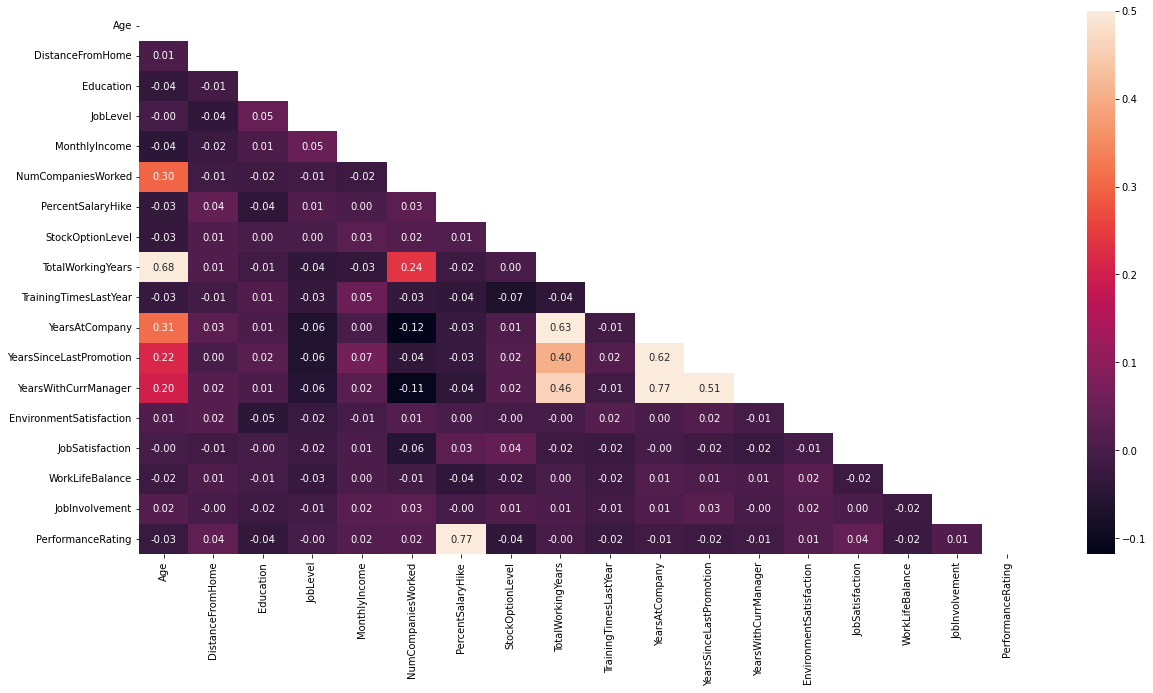

In [33]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(matrix,annot=True,vmax=0.5, mask=np.triu(df.corr()), fmt=".2f")

Feature reduction/ selection by finding highly correlated features (0.6-0.9 = good correlation). This heatmap shows that the following have a high correlation:
* PercentageSalaryHike : PerformanceRating
* YearsAtCompany : YearWithCurrManager
* Age : TotalWorkingYears
* TotalWorkingYears : YearsAtCompany ?
* YearsAtCompany : YearsSinceLastPromotion ?

#### Features vs Attrition

<AxesSubplot:xlabel='Attrition', ylabel='count'>

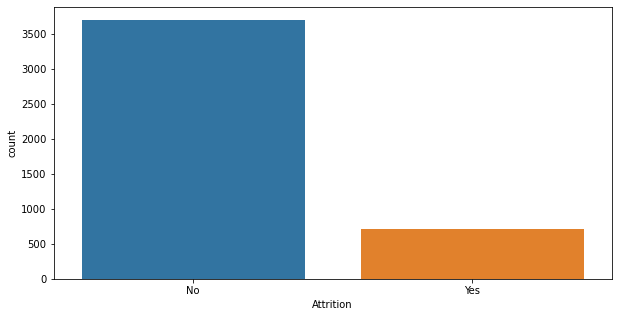

In [34]:
plt.figure(figsize = ( 10,5))
sns.countplot(x = 'Attrition', data = df)

Imbalanced labels will require treatment with SMOTE for machine learning

In [35]:
# Change ordinal columns to categorical i.e. Eduaction, Performace Rating and Work Life Balance 
df.Education = df.Education.map({1: 'Below College', 2: 'College', 3: 'Bachelor' , 4: 'Master' , 5: 'Doctor'}) 
df.PerformanceRating = df.PerformanceRating.map({1: 'Low', 2: 'Good', 3: 'Excellent' , 4: 'Outstanding'}) 
df.WorkLifeBalance = df.WorkLifeBalance.map({1: 'Bad', 2: 'Good', 3: 'Better' , 4: 'Best'}) 

In [36]:
# import in_time and out_time data
dt=pd.read_csv('mean_n_attendence.csv',index_col=0)

In [37]:
df=df.join(dt)

Categorical features: BusinessTravel, Department, Education, EducationField, Gender, JobLevel, JobRole, Marital Status,
StockOptionLevel, EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance, JobInvolvement

In [38]:
# from raw value to percentage
def percent_plot(x,y):
    total = df.groupby(x)[y].value_counts(normalize=True)
    total = total.mul(100)
    total= total.rename('percent').reset_index()
    # plot
    g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=total, height=5, aspect=3)
    g.ax.set_ylim(0,100)
    #legend&lables
    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)
    return

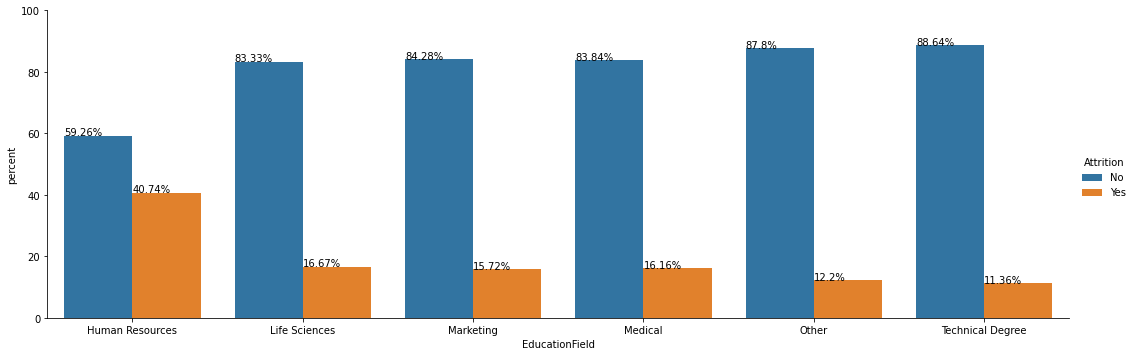

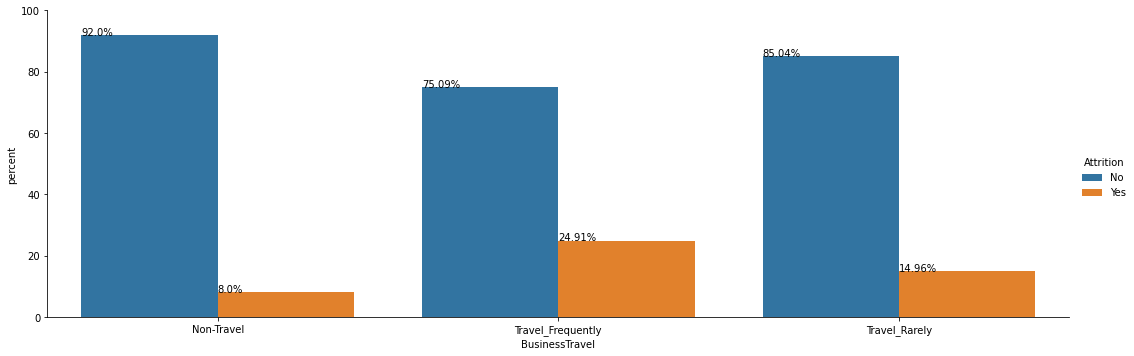

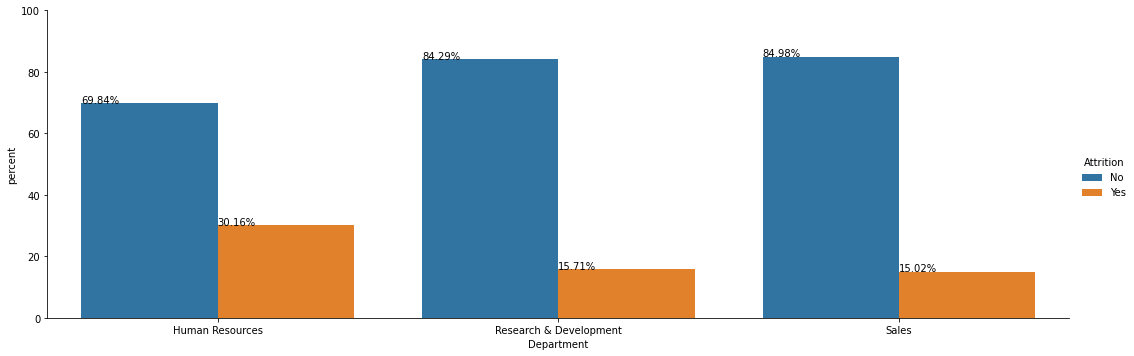

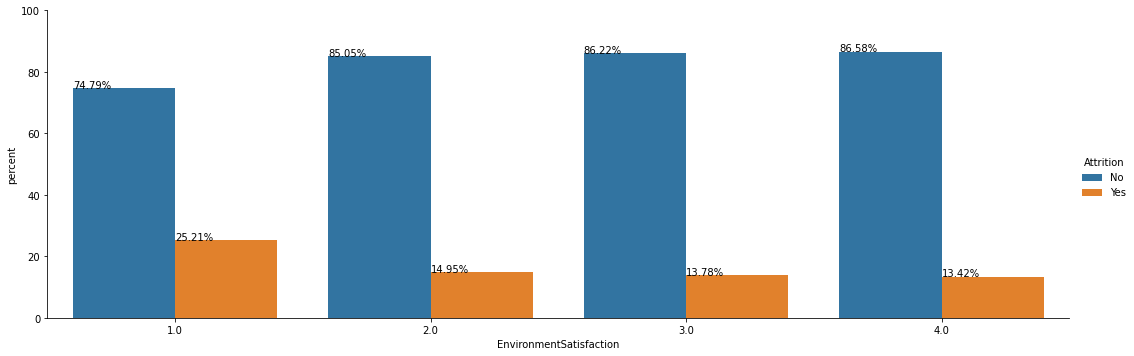

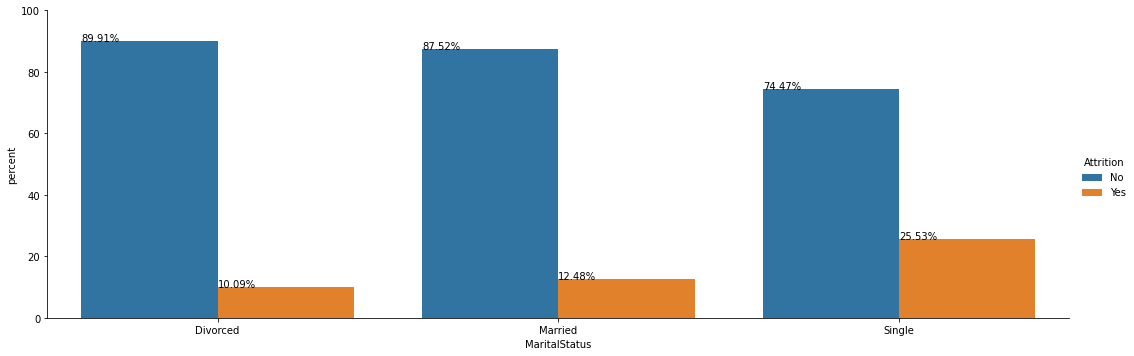

In [39]:
#Checking features against Attrition
percent_plot('EducationField','Attrition')
percent_plot('BusinessTravel','Attrition')
percent_plot('Department','Attrition')
percent_plot('EnvironmentSatisfaction','Attrition')
percent_plot('MaritalStatus','Attrition')

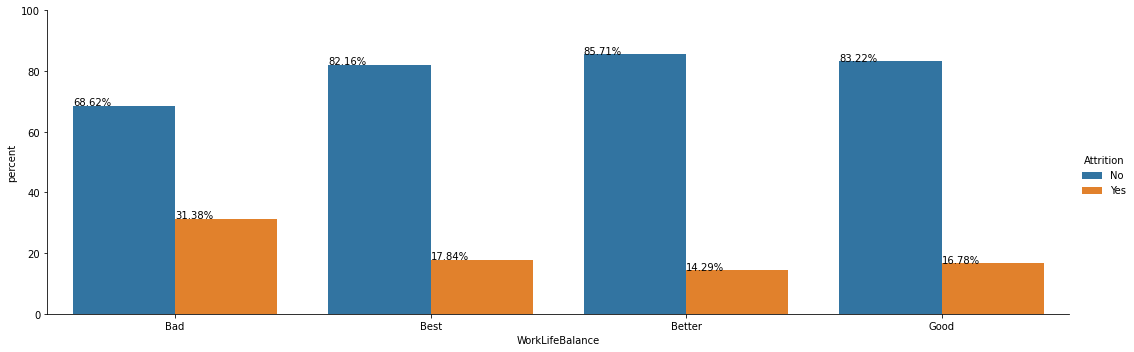

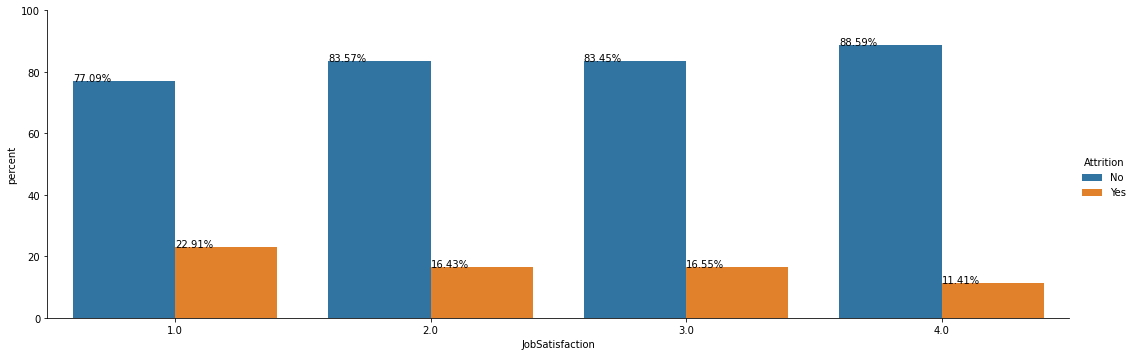

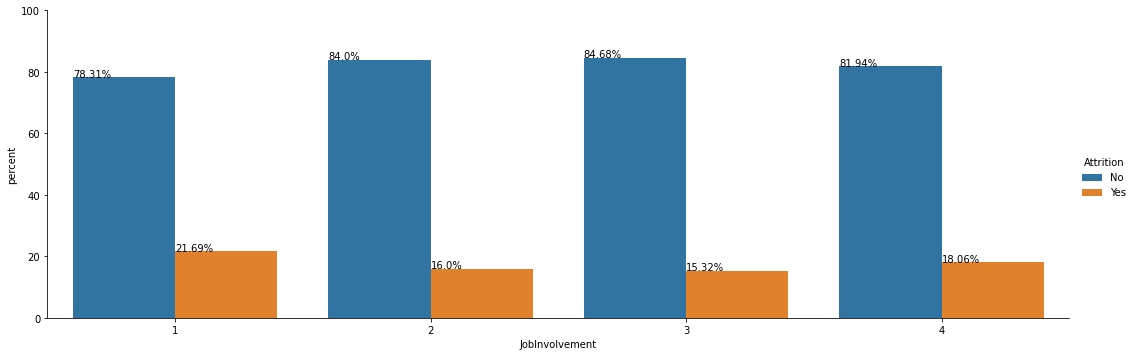

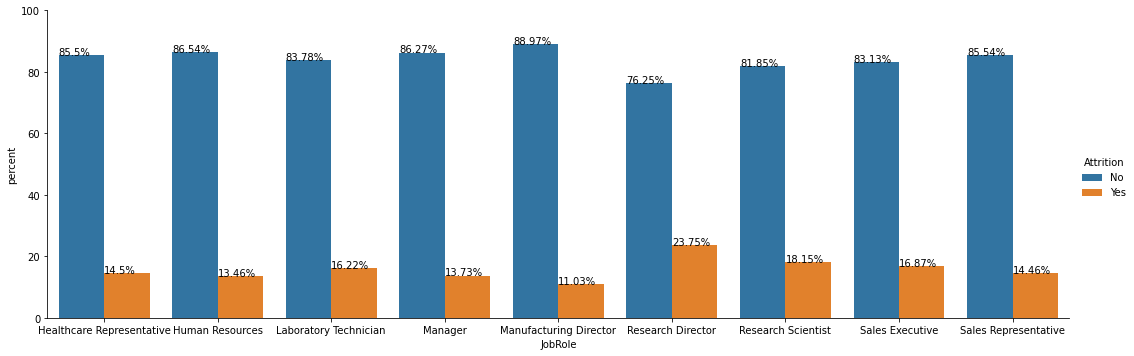

In [40]:
percent_plot('WorkLifeBalance','Attrition')
percent_plot('JobSatisfaction','Attrition')
percent_plot('JobInvolvement','Attrition')
percent_plot('JobRole','Attrition')

After checking all categorical features: BusinessTravel (having to travel frequently), Department/EducationField (HR), MaritalStatus (single), EnvironmentSatisfaction (low) and WorkLifeBalance (Bad) seem to be a factor for an employee leaving the company. 

Weak correlations: JobRole (Research Director), JobInvolvement (low), JobSatisfaction (low)

_____________________________________________________________________________________________________________________________

Continuous features: Age, DistanceFromHome, MonthlyIncome, NumCompaniesWorked, PercentSalaryHike, TotalWorkingYears, 
TrainingTimesLastYear, YearsAtCompany, YearsSinceLastPromotion, YearsWithCurrManager, mean, attendence 

In [41]:
# from raw value to percentage
def percent_line(x,y):
    total = df.groupby(x)[y].value_counts(normalize=True)
    total= total.rename('percent').reset_index()
    # plot
    plt.figure(figsize = (15,5))
    sns.pointplot(x=x,y='percent', marker='o',hue=y,data=total)
    return

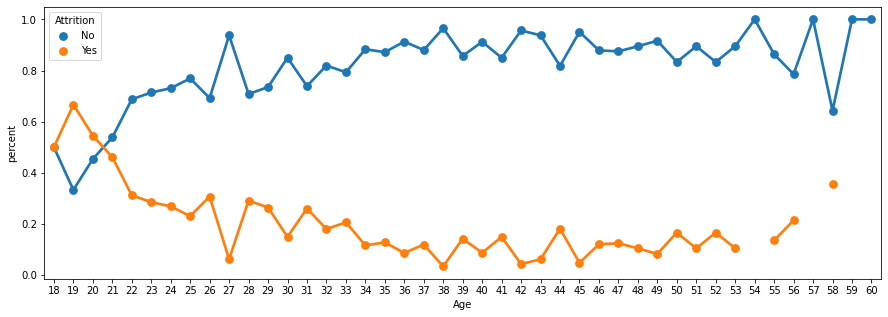

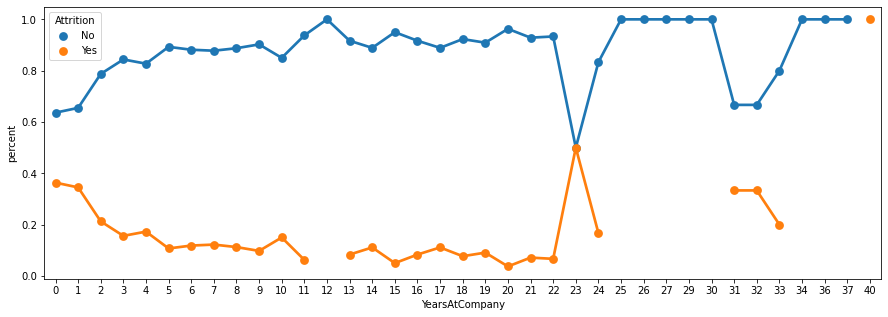

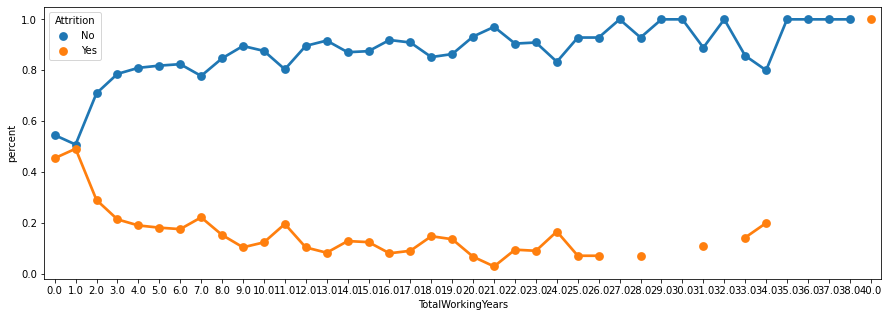

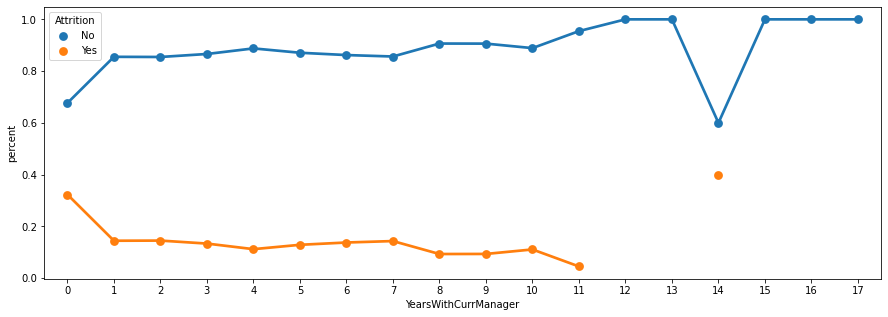

In [42]:
percent_line('Age','Attrition')
percent_line('YearsAtCompany','Attrition')
percent_line('TotalWorkingYears','Attrition')
percent_line('YearsWithCurrManager','Attrition')

After checking all continuous features: Age (and thus total years working) seem to be a factor for an employee leaving the company. Its worth noting that around 23 years at the company and 14 years with curr manager gives a higher level of attrition, but these maybe anomolies.

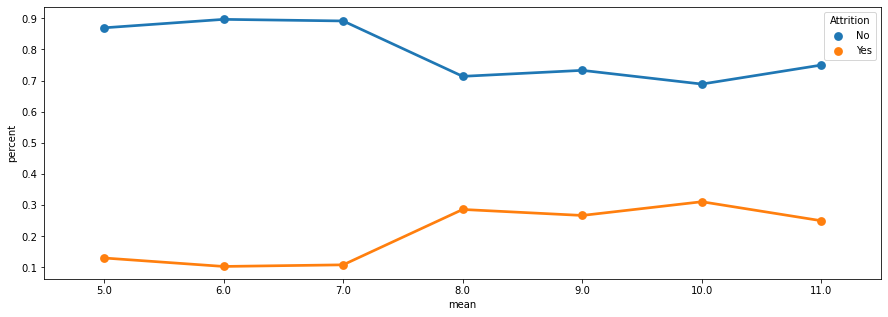

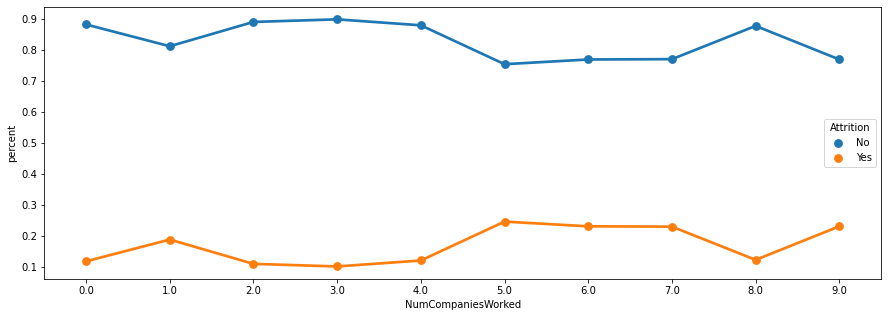

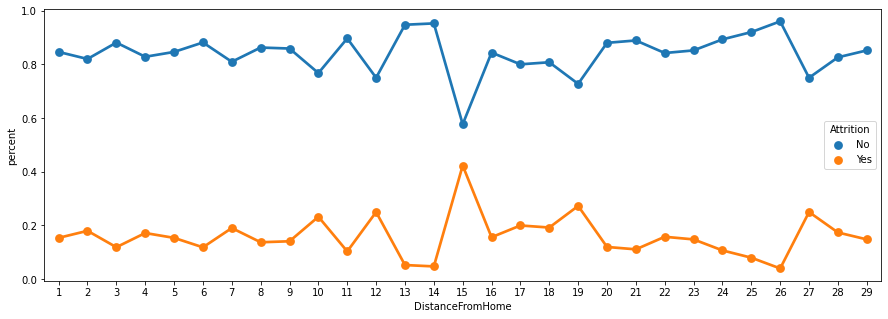

In [43]:
percent_line('mean','Attrition')
percent_line('NumCompaniesWorked','Attrition')
percent_line('DistanceFromHome','Attrition')

Higher working hours show an increase in attrition. DistanceFromHome and NumComapnies worked may also affect attrition. 

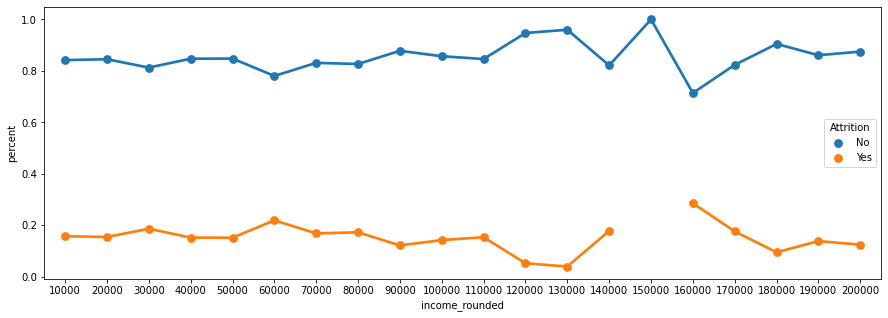

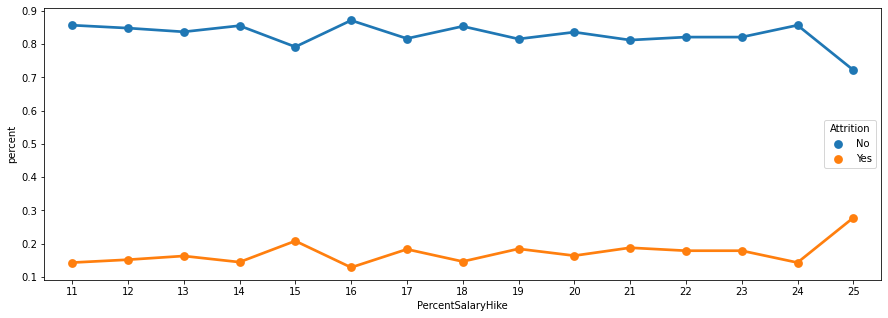

In [45]:
# Monthly income 
df['income_rounded']=df['MonthlyIncome'].round(-4)
percent_line('income_rounded','Attrition')
percent_line('PercentSalaryHike','Attrition')

Monthly income & PercentSalaryHike does not have a clear correlation with attrition.

In [46]:
df.to_csv('combinedsdata.csv')

#### Reasoning

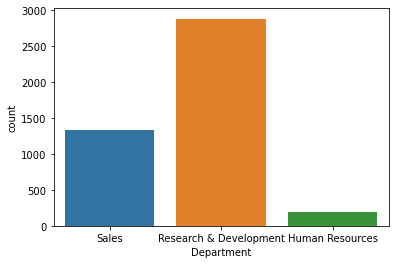

In [47]:
# count of categorical features
sns.countplot(x = 'Department',data = df)
plt.show()

High level of attrition for the HR department maybe as a result of the department being small.